In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import time
import ipywidgets as wg
from ipywidgets import interact
from IPython.display import display
import networkx as nx
from src.environment import Environment
from src.runner import runner
from sklearn import preprocessing
import random
import json
import geopy.distance

In [2]:
style.use('seaborn-white')

# Setting the parameters

In [3]:
age_groups = ['age_0_10', 'age_10_20', 'age_20_30', 'age_30_40', 'age_40_50', 
              'age_50_60', 'age_60_70', 'age_70_80', 'age_80_plus']

In [39]:
parameters = {
    # general simulation parameters
    "time": 90,
    "number_of_agents": 500,
    "monte_carlo_runs": 5,
    "high_performance": False,
    # specific simulation parameters
    "share_inital_agents_infected": 0.01, # percentage of agents infected randomly at the start of the simulation
    "highest_density_neighbourhood": 0.4, # percentage of nodes the highest density neighbourhoods has compared to caveman graph
    "incubation_days": 5, # average number of days agents are infected but do not have symptoms SOURCE Zhang et al. 2020
    "symptom_days": 10,# average number of days agents have mild symptoms
    "critical_days": 8, # average number of days agents are in critical condition
    "health_system_capacity": 0.0021, # relative (in terms of population) capacity of the hospitals
    "no_hospital_multiplier": 1.79, # the increase in probability if a critical agent cannot go to the hospital SOURCE: Zhou et al. 2020
    "travel_sample_size": 0.02, # amount of agents that an agent might choose to travel to
    "foreign_infection_days": [x for x in range(0, 19)], # days at which 1 agent will be infected every day from abroad 
    # agent parameters
    "probability_transmission": 0.30, # should be estimated to replicate realistic R0 number.
    "probability_to_travel": 0.25, # should be estimated to replicate travel data 
    "probability_critical": {key:value for key, value in zip(age_groups, [0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.244, 0.273])}, # probability that an agent enters a critical stage of the disease SOURCE: Verity et al.
    "probability_to_die": {key:value for key, value in zip(age_groups, [0.005, 0.021, 0.053, 0.126, 0.221, 0.303, 0.565, 0.653, 0.765])}, # probability to die per age group in critical stage SOURCE: Verity et al.
    "probability_susceptible": 0.000, # probability that the agent will again be susceptible after having recovered
    # experiment parameter
    "lockdown_days" : [0 for x in range(11, 46)], # in the baseline this is 0, 5 march was the first reported case, 27 march was the start of the lockdown 35 days
    "lockdown_travel_multiplier": 1.0 - ((0.85 + 0.62) / 2), # need estimate for this based on apple travel data reduction of 85% google work of -62% for Western Cape
    "lockdown_infection_multiplier": 0.27, # Jarvis et al. 2020
    "informality_dummy": 0.0, # setting this parameter at 0 will mean the lockdown is equally effective anywhere, alternative = 1
    "at_risk_groups": [] # leave list empty for baseline  #age_groups[-4:]
}

Store parameters in JSON file.

In [40]:
with open('parameters/baseline/parameters.json', 'w') as outfile:
    json.dump(parameters, outfile)

In [41]:
# load parameters
with open('parameters/baseline/parameters.json') as json_file:
    parameters = json.load(json_file)

# Generate district data using Ward data from Cape Town

Take into account informality of the different districts.

In [42]:
inital_infections = pd.read_csv('input_data/Cases_With_Subdistricts.csv', index_col=0)

In [43]:
informal_residential = pd.read_csv('input_data/Informal_Residential.csv').iloc[:-1]

In [44]:
# Create x, where x the 'scores' column's values as floats
x = informal_residential[['Informal_residential']].values.astype(float)

# # Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# # Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# # Run the normalizer on the dataframe
informal_residential['Informal_residential'] = pd.DataFrame(x_scaled)

In [45]:
population = pd.read_csv('input_data/population.csv')

In [46]:
population['Informal_residential'] = informal_residential['Informal_residential']

In [47]:
population.head(3)

,WardID,Population,Area,Density,lon,lat,Informal_residential
0,19100001,26434.07345,27213.359916,0.971364,18.612025,-33.857307,0.0
1,19100002,29914.18993,9222.458013,3.243624,18.422324,-34.069837,0.0
2,19100003,25735.62250,10891.277732,2.362957,18.476290,-34.048938,0.0


Because the amount of agents are less than in the actual population of Cape Town, we filter some wards so that all of them are at least populated with an agent. Therefore, we calculate the smallest size of a neighbourhood should have as follows.

In [48]:
smallest_size = population['Population'].sum() / parameters['number_of_agents']

Next, we tranform the districts to a list format that feeds into the model. 

In [49]:
districts_data = []
for i in range(len(population)):
    if population['Population'].iloc[i] > smallest_size:
        districts_data.append(
            [int(population['WardID'].iloc[i]), {'Population': population['Population'].iloc[i],
                                                 'Density': population['Density'].iloc[i],
                                                 'lon': population['lon'].iloc[i],
                                                 'lat': population['lat'].iloc[i],
                                                 'Informal_residential': population['Informal_residential'].iloc[i],
                                                 'Cases_With_Subdistricts': inital_infections.loc[population['WardID'].iloc[i]]['Cases_03292020'],
                                                },
            ])
max_neighbourhoods = len(districts_data)

In [50]:
cases = [x[1]['Cases_With_Subdistricts'] for x in districts_data]
probabilities = norm = [float(i)/sum(cases) for i in cases]
#probabilities

If you want to do a smaller trial run of the model you can further limit the amount of districts by setting the following parameter. 

In [51]:
max_districts = len(districts_data)

In [52]:
with open('parameters/baseline/district_data.json', 'w') as outfile:
    json.dump(districts_data[:max_districts], outfile)

In [53]:
# load neighbourhood data
with open('parameters/baseline/district_data.json') as json_file:
    districts_data = json.load(json_file)

# Create a distance matrix between the districts

In [54]:
districts = [districts_data[x][0] for x in range(len(districts_data))]

distance_table = {}

for idx1, n1 in enumerate(districts):
    distance_to_n1 = []
    for idx2, n2 in enumerate(districts):
        loc1 = districts_data[idx1][1]['lon'], districts_data[idx1][1]['lon']
        loc2 = districts_data[idx2][1]['lon'], districts_data[idx2][1]['lon']
        distance12 = geopy.distance.geodesic(loc1, loc2).km
        distance_to_n1.append(distance12)
    distance_table[n1] = distance_to_n1

In [55]:
distance_matrix = pd.DataFrame(distance_table)
distance_matrix.index = districts

In [56]:
distance_matrix.to_csv('parameters/baseline/distance_matrix.csv')

In [57]:
distance_matrix = pd.read_csv('parameters/baseline/distance_matrix.csv', index_col=0)

### Load age data

In [58]:
# load age data
age_distribution = pd.read_csv('input_data/age_dist.csv', sep=';', index_col=0)
age_distribution_per_ward = dict(age_distribution.transpose())

The next step is to either run the model in the SABCoModel.py file or run it here in the notebook. When running it in the notebook the initialization starts here. 

# Initialization

In [59]:
environment = Environment(0, parameters, districts_data, age_distribution_per_ward, distance_matrix)

# Simulation

In [60]:
data_folder = 'measurement/baseline/'

environment = runner(environment, 0, data_folder=data_folder)

### Save network data

In [61]:
for idx, network in enumerate(environment.infection_states):
    for i, node in enumerate(network.nodes):
        network.nodes[i]['agent'] = network.nodes[i]['agent'].status

    nx.write_graphml_lxml(network, "measurement/baseline/network_time{}.graphml".format(idx))

### Read data 

In [62]:
infection_states = []
for idx in range(parameters["time"]):
    infection_states.append(nx.read_graphml("measurement/baseline/network_time{}.graphml".format(idx), node_type=int))

## Draw

In [63]:
pos = nx.spring_layout(infection_states[0])

In [64]:
def plot_model(t):
    network = infection_states[t]
    color_map = []
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            color_map.append('blue')
        elif network.nodes[idx]['agent'] == 'i1':
            color_map.append('pink')
        elif network.nodes[idx]['agent'] == 'i2':
            color_map.append('red')
        elif network.nodes[idx]['agent'] == 'c':
            color_map.append('brown')
        elif network.nodes[idx]['agent'] == 'd':
            color_map.append('black')
        elif network.nodes[idx]['agent'] == 'r':
            color_map.append('grey')
    nx.draw(network, pos=pos, node_color=color_map, with_labels=True)

In [65]:
time_period = wg.IntSlider(description='Time step', min=0, max=parameters['time']-1)
wg.interact(plot_model, t=time_period)

interactive(children=(IntSlider(value=0, description='Time step', max=89), Output()), _dom_classes=('widget-in…

<function __main__.plot_model(t)>

Graph

In [66]:
susceptible_ot = []
infected_1_ot = []
infected_2_ot = []
critical_ot = []
dead_ot = []
recovered_ot = []

for t in range(parameters['time']):
    network = infection_states[t]
    susceptible = 0
    infected_1 = 0
    infected_2 = 0
    critical = 0
    dead = 0
    recovered = 0
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            susceptible += 1
        elif network.nodes[idx]['agent'] == 'i1':
            infected_1 += 1
        elif network.nodes[idx]['agent'] == 'i2':
            infected_2 += 1
        elif network.nodes[idx]['agent'] == 'c':
            critical += 1
        elif network.nodes[idx]['agent'] == 'd':
            dead += 1
        elif network.nodes[idx]['agent'] == 'r':
            recovered +=1
        else:
            print('no status?')
    
    susceptible_ot.append((susceptible / float(len(network))) * population['Population'].sum())
    infected_1_ot.append((infected_1 / float(len(network))) * population['Population'].sum())
    infected_2_ot.append((infected_2 / float(len(network)))  * population['Population'].sum())
    critical_ot.append((critical / float(len(network)))  * population['Population'].sum())
    dead_ot.append((dead / float(len(network)))  * population['Population'].sum())
    recovered_ot.append((recovered / float(len(network)))  * population['Population'].sum())

(0, 3740030.74811)

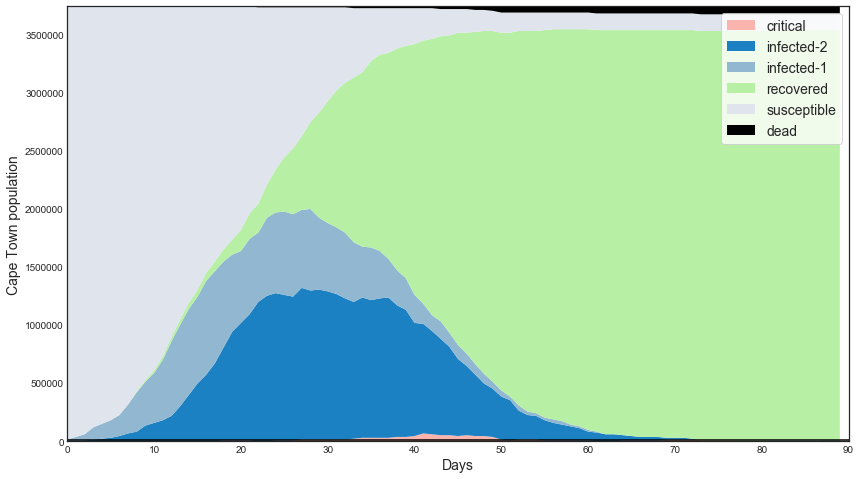

In [67]:
fig, ax = plt.subplots(figsize=(14,8))

x = [x for x in range(parameters['time'])]

labels = ['critical', 'infected-2', 'infected-1', 'recovered', 'susceptible', 'dead']

y = np.vstack([critical_ot, infected_2_ot, infected_1_ot, recovered_ot, susceptible_ot, dead_ot])

ax.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

ax.stackplot(x, y, colors= pal, labels=labels)
ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cape Town population', fontsize='14')
ax.set_xlabel('Days', fontsize='14')

plt.xlim([0,parameters['time']])
plt.ylim([0, population['Population'].sum()])

#fig.savefig('measurement/the_curve.png')

# Plot curves per Ward: